### Off-Policy Policy Evaluation on a discrete MDP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import time
import tqdm

from collections import defaultdict
from os import listdir, getcwd
from os.path import isabs, join, isfile
import re

from model import Agent
import utils
from estimator import IS

In [2]:
#create gym environment
env_name = "Taxi-v3"
env = gym.make(env_name)
env = env.unwrapped #gets ride of TimeLimit

In [3]:
agent = Agent(env) #create TD agent

In [4]:
def load_policies(path):
    """Loads all policies in a directory"""
    cwd = getcwd() #get current working directory
    index = lambda idx : int(re.findall(r'[0-9]+', idx)[0]) #get policy number
    def model(f):
        policy = utils.load_policy(f) if ".npy" in f else None #load agent
        if(policy is None):
            return None
        agx = Agent(env)
        agx.Q = policy
        return agx
    
    return {index(f): model(join(path, f)) for f in listdir(join(cwd, path)) if isabs(join(cwd, f)) and model(join(path, f)) is not None}

In [5]:
matrix = load_policies("../model/")

In [6]:
def store_agents(indices):
    """Store selected list of agents given by their keys"""
    agx, idx = [0]*len(indices), [0]*len(indices)
    for i, elem in enumerate(indices):
        agx[i] = matrix[elem]
        idx[i] = elem
    return agx, idx

In [7]:
agents, idx = store_agents([8, 9])

## Step 2 - generate policy matrix
<p> A policy matrix is a dictionary of dimensions (K, K - 1), where K is the total number of behavior policies </p>

In [8]:
def policy_matrix(agents):
    """Generates policy matrix (dictionary) of shape (n, n-1) for x agents"""
    matrix = {}
    for i, evaluation in enumerate(agents):
        matrix[evaluation] = []
        for j, behavior in enumerate(agents):
            if(i != j):
                matrix[evaluation].append(behavior)
    return matrix        

In [9]:
#each key indicates evaluation policy, and corresponding values indicate behavior policies
policy_dict = policy_matrix(agents)

In [10]:
def get_behavior_policies(evaluation_policy):
    """Generates respective behvaior policies for a particular evaluation policy"""
    return policy_dict[evaluation_policy] if evaluation_policy in policy_dict.keys() else None

## Step 3. Importance Sampling

$$ \xi_k =  \prod_{t=1}^{H} \frac{ \pi_e({a_t}^k | {s_t}^k) }{ \pi_k({a_t}^k | {s_t}^k) } $$

### Regression Importance Sampling to approximate for the behavior policy
> RIS paper: http://proceedings.mlr.press/v97/hanna19a/hanna19a.pdf

$$\tag{1} \pi_{D}(a | h_{i - n:i}) := \frac{c(h_{i - n:i}, a)}{c(h_{i - n:i})} $$
- $c(h_{i:j}, a)$ is the count of number of times that action $a$ is observed following trajectory segment $h_{i:j}$ during any trajectory $D$.
- $c(h_{i:j})$ is the count of number of times that trajectory segment $h_{i:j}$ appears during any trajectory in $D$.
- Note, that we can calculate maximum-likelihood behavior policy with count based estimates

Incorporating $(1)$ to compute RIS:
$$ RIS{(n)}(\pi_e, D) := \frac{1}{m} \sum\limits_{i=1}^m g(H_i) \prod\limits_{t=0}^{L-1} \frac{ \pi_e(A_t|S_t) }{ {\pi_D}^{(n)}(A_t|H_{t-n:t}) } $$
- $g(H_i)$ is the discounted return of trajectory H

In [11]:
sampling_function = IS(env, "RIS").func

## Step 4. Get Trajectories

$$ \sigma(\pi_e, \pi_k) = \sum\limits_{i=1}^N {R_k}^i \times {\xi_k}^i  $$

In [12]:
def get_trajectories(evaluation_agent, behavior_agent, N, type):
    """
    See formula above.
    Calculates the sum of value for a behavior policy and corresponding evaluation policy
    based on N trajectories.
    
    > Importance Sampling ratio, 𝜉
    > Compute sigma that represents inner sum for 1 behavior policy and corresponding evaluation policy
    
    @Param:
    1. evaluation_agent - (Agent) Evaluation Policy
    2. behavior_agent - (Agent) Behavior Policy
    3. N - (int) number of trajectories
    4. type - (int) 0/1 representing x_1 (0) and x_2 (1) for matrix multiplication later.
    @Return 
    - sigma = (float) returns inner sum, sigma (see formula for more details).
    """
    sigma = 0
    for _ in range(N):
        xi, reward = sampling_function(evaluation_agent, behavior_agent)
        sigma += reward * xi if(type == 0) else reward #X_2 doesn't use xi because it's distributed later.
    return sigma

## Step 5. Calculate function value

$$ f(\hat{\pi}) = \frac{1}{K N} \sum\limits_{k=1}^K \sigma(\pi_e, \pi_k) $$

In [13]:
def function(behavior_agents, evaluation_agent, N, type):
    """
    Computes f(π) using formula shown above.
    @Param:
    1. behavior_agent: (list) list of Agent class objects representing set of evaluation for given π_e.
    2. evaluation_agents: π_e (Agent) behavior policy
    3. N - (int) number of trajectories (used in calculation of sigma in `get_trajectories`)
    4. type: (int) 0/1 for calculation of X_1/X_2 with regards sum of products w.r.t constants, c and d.
    @Return
    - value: (float) value of function f(π) using formula above.
    """
    value = 0
    K = len(behavior_agents)
    for agent in behavior_agents:
        sigma = get_trajectories(evaluation_agent, agent, N, type)
        value += sigma
    
    return float(value / (K * N))

## Step 6. True Value function for an evaluation agent

$$ V(\pi_e) = \frac{1}{N} \sum\limits_{i=1}^N {R_e}^i $$

In [14]:
def Value(policy_dict, N):
    """
    Calculates the expected return for all evaluation agents
    @Param: 
    1. policy_dict - (dict[list]) policy matrix of shape (n, n-1) for n agents.
    2. N - (int) number of trajectories to run value estimation for.
    NOTE: N should equal with estimation value function parameter N.
    @Return:
    - values - (nd.array) Vector of values of evaluation policies using formula shown above. 
    """
    evaluation_agents = list(policy_dict.keys()) #generate n eval agents
    values = [0]*len(evaluation_agents) #vector of values of evaluation policies
    for i, agent in enumerate(evaluation_agents):
        value = [] #stores N Return for agent with policy π_e.
        for n in range(N):
            total_reward = 0
            state = env.reset() #reset
            counter = 0
            while True:
                action, prob = agent.get_action(agent.Q, state, eps=0)
                next_state, reward, done, info = env.step(action)
                total_reward += reward
                state = next_state
                counter += 1
                if(done or counter > 500): break
                    
            #append to value
            value.append(total_reward)
        #compute mean return and store in vector of values.
        expected_val = np.mean(value)
        values[i] = expected_val
    
    return np.array([values]).T #dim = number of agents.

## Step 7. Tying it al together!

In [15]:
#retrieve an evaluation policy with agent of index i.
get_eval_agent = lambda i: list(policy_dict.keys())[i - 1]

In [16]:
def main(policy_dict, N):
    """
    Main function for generating X_1 and X_2 of shapes k each, where k = number of base policies
    @Param:
    1. policy_dict - (dict[list]) policy matrix of shape (n, n-1) for n agents.
    2. N - (int) number of trajectories to run value estimation for.
    @Return:
    - X: (nd.array) concatenation of X_1 and X_2
    """
    X_1, X_2 = [], [] #store X_1 and X_2 for k policies
    K = len(policy_dict.keys())
    
    for i in range(1, K + 1):
        ### compute X_1 with evaluation policy, π_e = π_i
        evaluation_agent = get_eval_agent(i)
        ### generate set of behavior policies for π_e = π_1, i.e. π_k = {[π_j] for j ≠ i}
        behavior_agents = get_behavior_policies(evaluation_agent)
        x1 = function(behavior_agents, evaluation_agent, N, 0) #compute x1
        x2 = function(behavior_agents, evaluation_agent, N, 1) #compute x2
        ### store values
        X_1.append(x1)
        X_2.append(x2)
        
    #typecast to nd.array
    X_1 = np.array([X_1])
    X_2 = np.array([X_2])
#     ones = np.ones(X_1.shape)
    X = np.hstack((X_1.T, X_2.T)) #concat
    
    #Test dimensions
    assert(X.shape == (K, 2))
    return X

In [17]:
### calculate X with 50 trajectories
X = main(policy_dict, 1000)
### generate true value estimate
true_values = Value(policy_dict, 1000)

In [19]:
c, d, e = 0,0,0
coeffs = np.array([[c, d]]).T

output = np.dot(X, coeffs) + e
error = np.sum(np.square(output - true_values))
print("Error = ", error)
print("Expected Return = ", true_values.mean())

Error =  125.740004
Expected Return =  7.929


In [38]:
def translate(data):
    data = data.split("\n")
    temp_mse = []
    temp_rew = []
    for line in data:
        mse, reward = line.split("\t")
        temp_mse.append(float(mse))
        temp_rew.append(float(reward))
    
    return temp_mse, temp_rew

In [46]:
ois_1 = """143605.12319999997	-260.085
129491.640608	-246.548
48438.903752	-147.783
0.02622050000000002	7.871499999999999
0.003527999999999969	7.913
0.011400500000000105	7.8725000000000005
0.00980000000000008	7.961
0.004608000000000008	7.878"""

##########
ris_1 = """146025.26694449998	-262.3365
129443.80805	-246.595
64821.9618605	-171.9905
0.0007604999999999884	7.8675
0.0021125000000000254	7.9384999999999994
9.800000000000328e-05	7.827999999999999
0.0073205000000000535	8.0095
0.0009679999999999821	7.881"""

##########

ois_2 = """274132.28000800003	-257.848
251063.015625	-246.5625
87436.74998500002	-143.8745
127.72836500000001	7.9915
126.243554	7.944
125.62077199999999	7.925
129.461341	8.0455
125.57965	7.9239999999999995"""

###########

ris_2 = """260181.81747999997	-251.02599999999998
251064.5209	-246.515
96676.79316500001	-151.4735
124.80451299999999	7.8995
123.339668	7.853
128.967632	8.03
129.355978	8.042
125.740004	7.929"""

In [83]:
ep = [1, 10, 1e3, 10e3, 25e3, 45e3, 50e3, 51e3]

In [84]:
m_ois1,r_ois1 = translate(ois_1)
m_ris1,r_ris1 = translate(ris_1)

m_ois2,r_ois2 = translate(ois_2)
m_ris2,r_ris2 = translate(ris_2)

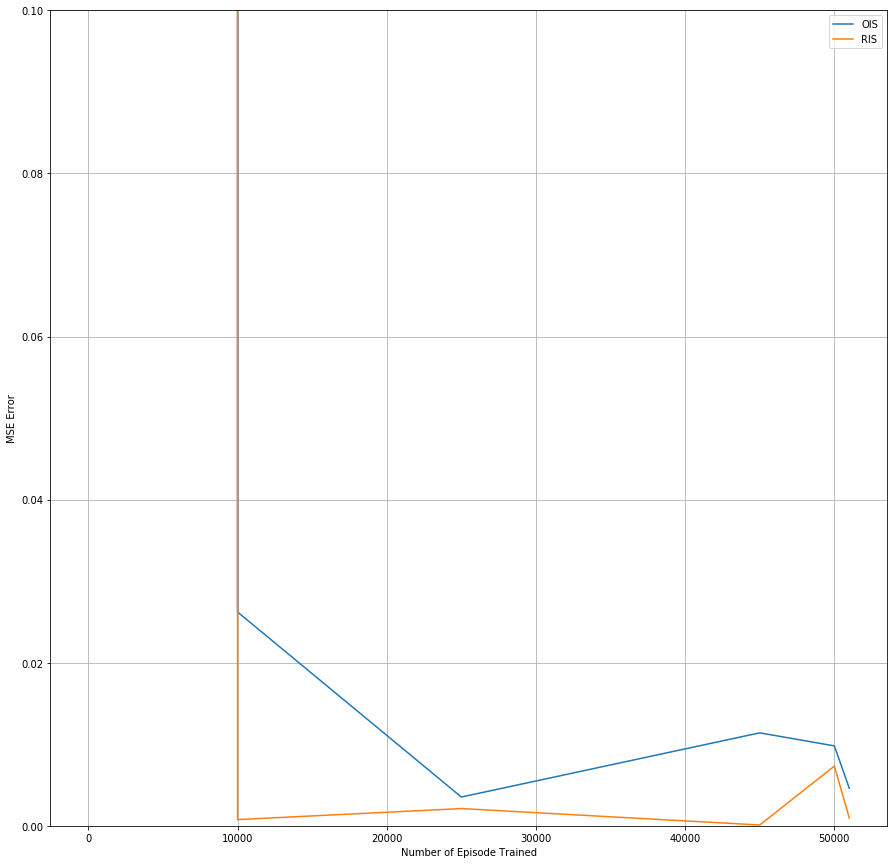

In [103]:
plt.figure(figsize=(15,15))

plt.plot(ep, m_ois1, label="OIS")
plt.plot(ep, m_ris1, label="RIS")
# plt.xlim([-10, 50e3])
plt.ylim([0,0.1])
plt.grid()
plt.legend()
plt.xlabel("Number of Episode Trained")
plt.ylabel("MSE Error")
plt.show()